In [1]:
import numpy as np
import pandas as pd
from fbprophet import Prophet

import palettable
from astropy.time import Time
from astropy.io import ascii
from astropy.table import Table

import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
rc('font', family='serif')

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%matplotlib inline

In [3]:
# You can also directly read the web link:
data = ascii.read('https://swift.gsfc.nasa.gov/results/transients/weak/RapidBurster.lc.txt', format='commented_header',header_start=-2)

#filter out bad data
err_avg=np.average(data['ERROR'])
#data = ascii.read('RapidBurster.lc.txt', format='commented_header',header_start=-2)
formatted_time = Time((data['TIME'][(data['ERROR']<err_avg)]),format='mjd',out_subfmt='date_hms').isot
formatted_data = Table([formatted_time,data['RATE'][(data['ERROR']<err_avg)]],names=['ds','y']).to_pandas()

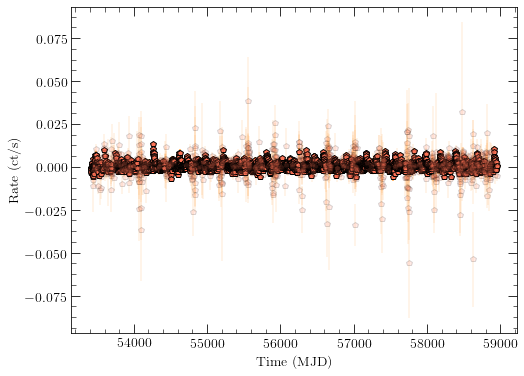

In [4]:
plt.figure(figsize=(8,6))

plt.errorbar(data['TIME']
[(data['ERROR']<err_avg)], data['RATE']
[(data['ERROR']<err_avg)], yerr=data['ERROR']
[(data['ERROR']<err_avg)], fmt='p',
             markeredgecolor='k',
             ecolor=palettable.cubehelix.cubehelix3_16.mpl_colors[11],
             color=palettable.cubehelix.cubehelix3_16.mpl_colors[10])

plt.errorbar(data['TIME']
[(data['ERROR']>err_avg)], data['RATE']
[(data['ERROR']>err_avg)], yerr=data['ERROR']
[(data['ERROR']>err_avg)], fmt='p',
             markeredgecolor='k',
             ecolor=palettable.cubehelix.cubehelix3_16.mpl_colors[11],
             color=palettable.cubehelix.cubehelix3_16.mpl_colors[10], alpha=0.15)

plt.minorticks_on()                                                              # To plot minor ticks
plt.tick_params(axis='both', which='major', labelsize=14)                        # To set tick label fontsize
plt.tick_params(axis='both', which='major', length=9)                            # To set tick size
plt.tick_params(axis='both', which='minor', length=4.5)                          # To set tick size
plt.tick_params(axis='both', which='both',direction='in',right=True, top=True)   # To plot ticks inwards instead of out
plt.xlim()
plt.xlabel('Time (MJD)', fontsize=14)
plt.ylabel('Rate (ct/s)', fontsize=14);

In [5]:
df = formatted_data

df_train=df[0:3800]
df_test=df[3800:]   # Note that element 3000 will be in df_train, but not in df_test (no need for 3001 instead of it)

In [6]:
### want to remove Mid Nov-Mid Jan every year from 2005 (MJD=53686, 53750) to 2020
#doesn't account for leap years but is close enough

data_gaps=[]
for i in range(0, 15 ):
    if np.shape(data_gaps)<1:
        data_gaps=np.arange(53686, 53750,1)
    else:
        data_gaps=np.append(data_gaps, np.arange(53686+(365*i), 53750+(365*i),1))


In [7]:
#Our "Holidays"!
no_obs= pd.DataFrame({
  'holiday': 'not-observed',
  'ds': Time(data_gaps,format='mjd',out_subfmt='date_hms').datetime,
  'lower_window': 0,
  'upper_window': 1,})

In [14]:
m = Prophet(yearly_seasonality=False,
                  weekly_seasonality=False,
                  daily_seasonality=False,
           holidays=no_obs,changepoint_prior_scale=.1)
m.fit(df_train)

In [15]:
future = m.make_future_dataframe(periods=665)
future.tail()

,ds
4460,2022-01-20
4461,2022-01-21
4462,2022-01-22
4463,2022-01-23
4464,2022-01-24


In [16]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
4460,2022-01-20,0.000724,-0.001918,0.003251
4461,2022-01-21,0.000724,-0.001567,0.003384
4462,2022-01-22,0.000724,-0.001738,0.003377
4463,2022-01-23,0.000724,-0.001661,0.003486
4464,2022-01-24,0.000724,-0.001613,0.003160


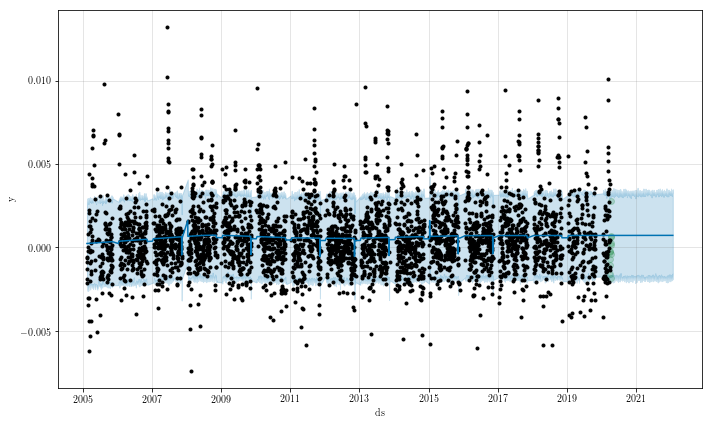

In [17]:
#plt.figure()
m.plot(forecast);
plt.plot_date(Time(data['TIME'][(data['ERROR']<err_avg)],format='mjd',out_subfmt='date_hms').datetime[3501:], data['RATE']
[(data['ERROR']<err_avg)][3501:], 'go', zorder=0, alpha=0.2)
#plt.xlim(Time(data['TIME'][(data['ERROR']<err_avg)],format='mjd',out_subfmt='date_hms').datetime[1000], Time(data['TIME'][(data['ERROR']<err_avg)],format='mjd',out_subfmt='date_hms').datetime[1000])

#plt.savefig('forecast_test.pdf')

In [12]:
###facebook discovered a seasonality in the dataset: every year between mid November-January, the source does not get observed. Let's put this in as a "Holiday"
#https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html

In [13]:
#let's try again!


